In [ ]:
!pip install -q tensorflow-probability

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd
import cv2, os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x_train = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TRAIN_Images.npy')/255.0
x_test = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TEST_Images.npy')/255.0
y_train = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TRAIN_Masks.npy')/255.0
y_test = np.load('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/TEST_Masks.npy')/255.0

# **Teacher VQVAE Loading**

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta
        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(shape=(self.embedding_dim, self.num_embeddings), dtype="float32"), trainable=True, name="embeddings_vqvae")
    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)
        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)+ tf.reduce_sum(self.embeddings ** 2, axis=0)- 2 * similarity)
        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

import keras.backend as K

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

Tvisky = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/vqvae_Teacher_4_twisky.h5', custom_objects = {
    'VectorQuantizer':VectorQuantizer, "tversky_loss":tversky_loss, "dice_score":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "matthews_correlation_coefficient":matthews_correlation_coefficient,
   "intersection_over_union":intersection_over_union, "jaccard_index":jaccard_index, "get_f1":get_f1 })
Tvisky.trainable = False

# **Student Modified UNet Building**

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

DICE = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_DICE.h5', custom_objects = {
   "dice_loss":dice_loss, "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })
DICE.trainable = True

# **Knowledge Distillation**

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
distiller = Distiller(student=DICE, teacher=Tvisky)
LOG = keras.callbacks.CSVLogger('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_BCE.csv',
                                separator=",", append=False)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[dice_score, keras.metrics.Recall(), keras.metrics.Precision(), get_f1, pixel_wise_accuracy, intersection_over_union],
    student_loss_fn=dice_loss, distillation_loss_fn=keras.losses.KLDivergence(), alpha=0.1, temperature=10)
history= distiller.fit(x_train, y_train, epochs=30, batch_size=16, validation_data = (x_test, y_test), callbacks = [LOG])

Epoch 1/30
313/313 [==============================] - 50s 78ms/step - dice_score: 0.7034 - recall: 0.5970 - precision: 0.8173 - get_f1: 0.7035 - pixel_wise_accuracy: 0.9738 - intersection_over_union: 0.3280 - student_loss: 0.2969 - distillation_loss: 7.2885e-04 - val_dice_score: 0.4804 - val_recall: 0.5092 - val_precision: 0.7626 - val_get_f1: 0.4794 - val_pixel_wise_accuracy: 0.9754 - val_intersection_over_union: 0.3021 - val_student_loss: 0.9997
Epoch 2/30
313/313 [==============================] - 16s 52ms/step - dice_score: 0.7034 - recall: 0.5983 - precision: 0.8171 - get_f1: 0.7036 - pixel_wise_accuracy: 0.9738 - intersection_over_union: 0.3533 - student_loss: 0.2970 - distillation_loss: 7.2908e-04 - val_dice_score: 0.4918 - val_recall: 0.5258 - val_precision: 0.7766 - val_get_f1: 0.4909 - val_pixel_wise_accuracy: 0.9759 - val_intersection_over_union: 0.2648 - val_student_loss: 0.9996
Epoch 3/30
313/313 [==============================] - 16s 51ms/step - dice_score: 0.7072 - recal

In [ ]:
distiller.save_weights('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Main_Distilled_Model_weights.h5')

In [ ]:
DICE.save('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_Distilled_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
preds = DICE.predict(x_train[3300:3400])
get_it = x_train[3300:3400]

4/4 [==============================] - 2s 136ms/step


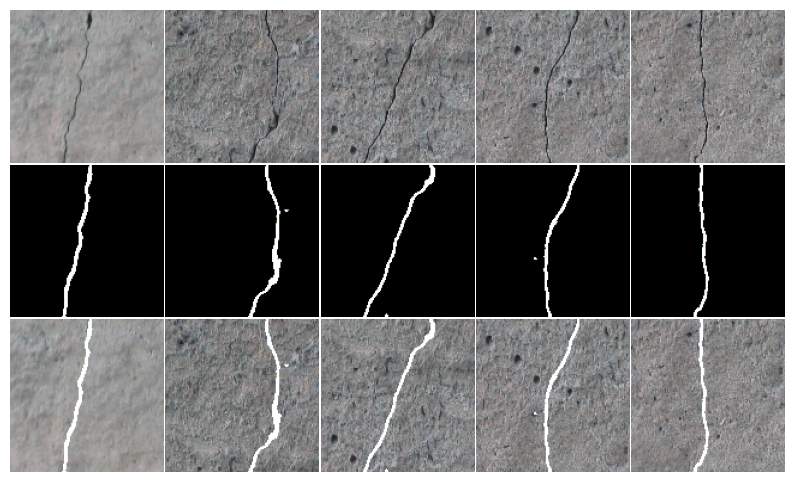

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('DISTILLED_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
from keras.models import load_model

from keras import backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model

smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def pixel_wise_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def mean_pixel_accuracy(y_true, y_pred):
    class_accuracy = K.mean(K.cast(K.equal(K.round(y_true), K.round(y_pred)), dtype='float32'), axis=0)
    return K.mean(class_accuracy)

def matthews_correlation_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    numerator = intersection
    denominator = K.sqrt(K.sum(y_true) * K.sum(y_pred))
    return K.cast(numerator / denominator, dtype='float32')

def intersection_over_union(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(iou, axis=-1)

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true + y_pred, axis=-1) - intersection
    jaccard = (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(jaccard, axis=-1)

# Custom Tversky Loss function
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    true_positives = tf.reduce_sum(y_true * y_pred)
    false_positives = tf.reduce_sum((1 - y_true) * y_pred)
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    tversky = (true_positives + 1e-5) / (true_positives + alpha * false_positives + beta * false_negatives + 1e-5)
    return 1 - tversky

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

# Custom Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Compute binary cross-entropy loss for each channel
    binary_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
    # Modify the loss for each channel
    focal_loss = alpha * (1 - tf.exp(-binary_ce)) ** gamma * binary_ce
    # Sum the loss across channels
    focal_loss = tf.reduce_sum(focal_loss, axis=-1)
    return tf.reduce_mean(focal_loss)

pre_dice = load_model('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Student_UNet_DICE.h5', custom_objects = {
   "dice_loss":dice_loss, "dice_coef":dice_score, "pixel_wise_accuracy":pixel_wise_accuracy,
    'mean_pixel_accuracy':mean_pixel_accuracy, "intersection_over_union":intersection_over_union, "get_f1":get_f1 })

In [ ]:
preds = pre_dice.predict(x_train[3300:3400])
get_it = x_train[3300:3400]

4/4 [==============================] - 0s 18ms/step


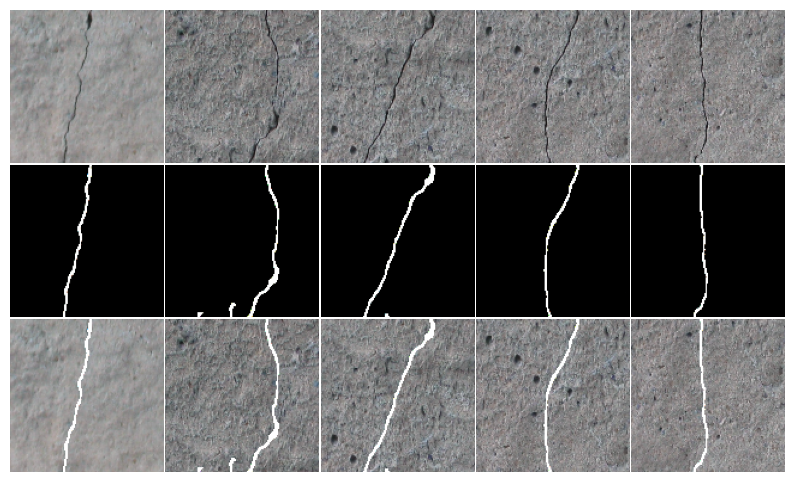

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Set figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Create a new figure
plt.figure()
sns.set_style("whitegrid", {'axes.grid' : False})

# Set only vertical spacing to zero
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Iterate through each column
for i in range(5):
    # Plot the original images
    plt.subplot(3, 5, i + 1)
    plt.imshow(get_it[i+6], aspect='auto')
    plt.axis('off')

    # Plot the predicted masks
    plt.subplot(3, 5, i + 6)
    plt.imshow(preds[i+6], aspect='auto')
    plt.axis('off')

    # Plot the extracted masks
    plt.subplot(3, 5, i + 11)
    plt.imshow(get_it[i+6] + preds[i+6], aspect='auto')
    plt.axis('off')

plt.savefig('without_Distilled_STUDENT.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
distil = pd.read_csv('/content/drive/MyDrive/Crack Analysis Project/VQ-VAE Paper/Crack_Segment_UNet_BCE.csv')

In [ ]:
distil.head()

,epoch,dice_score,distillation_loss,get_f1,intersection_over_union,pixel_wise_accuracy,precision,recall,student_loss,val_dice_score,val_get_f1,val_intersection_over_union,val_pixel_wise_accuracy,val_precision,val_recall,val_student_loss
0,0,0.703373,0.000957,0.703530,0.327989,0.973756,0.817317,0.597005,0.391411,0.480391,0.479388,0.302106,0.975391,0.762568,0.509218,0.999654
1,1,0.703447,0.000772,0.703569,0.353264,0.973767,0.817097,0.598343,0.427048,0.491792,0.490915,0.264795,0.975887,0.776648,0.525777,0.999637
2,2,0.707243,0.000386,0.707338,0.384575,0.973952,0.817547,0.604146,0.338450,0.491945,0.490741,0.301377,0.974614,0.747468,0.548429,0.999810
3,3,0.707752,0.000770,0.707869,0.412385,0.974095,0.820626,0.600223,0.441959,0.494292,0.480436,0.529063,0.974298,0.744567,0.525747,0.999215
4,4,0.708106,0.000526,0.708220,0.445901,0.974107,0.819354,0.603094,0.256720,0.487811,0.486536,0.436292,0.975612,0.780626,0.496491,0.999891


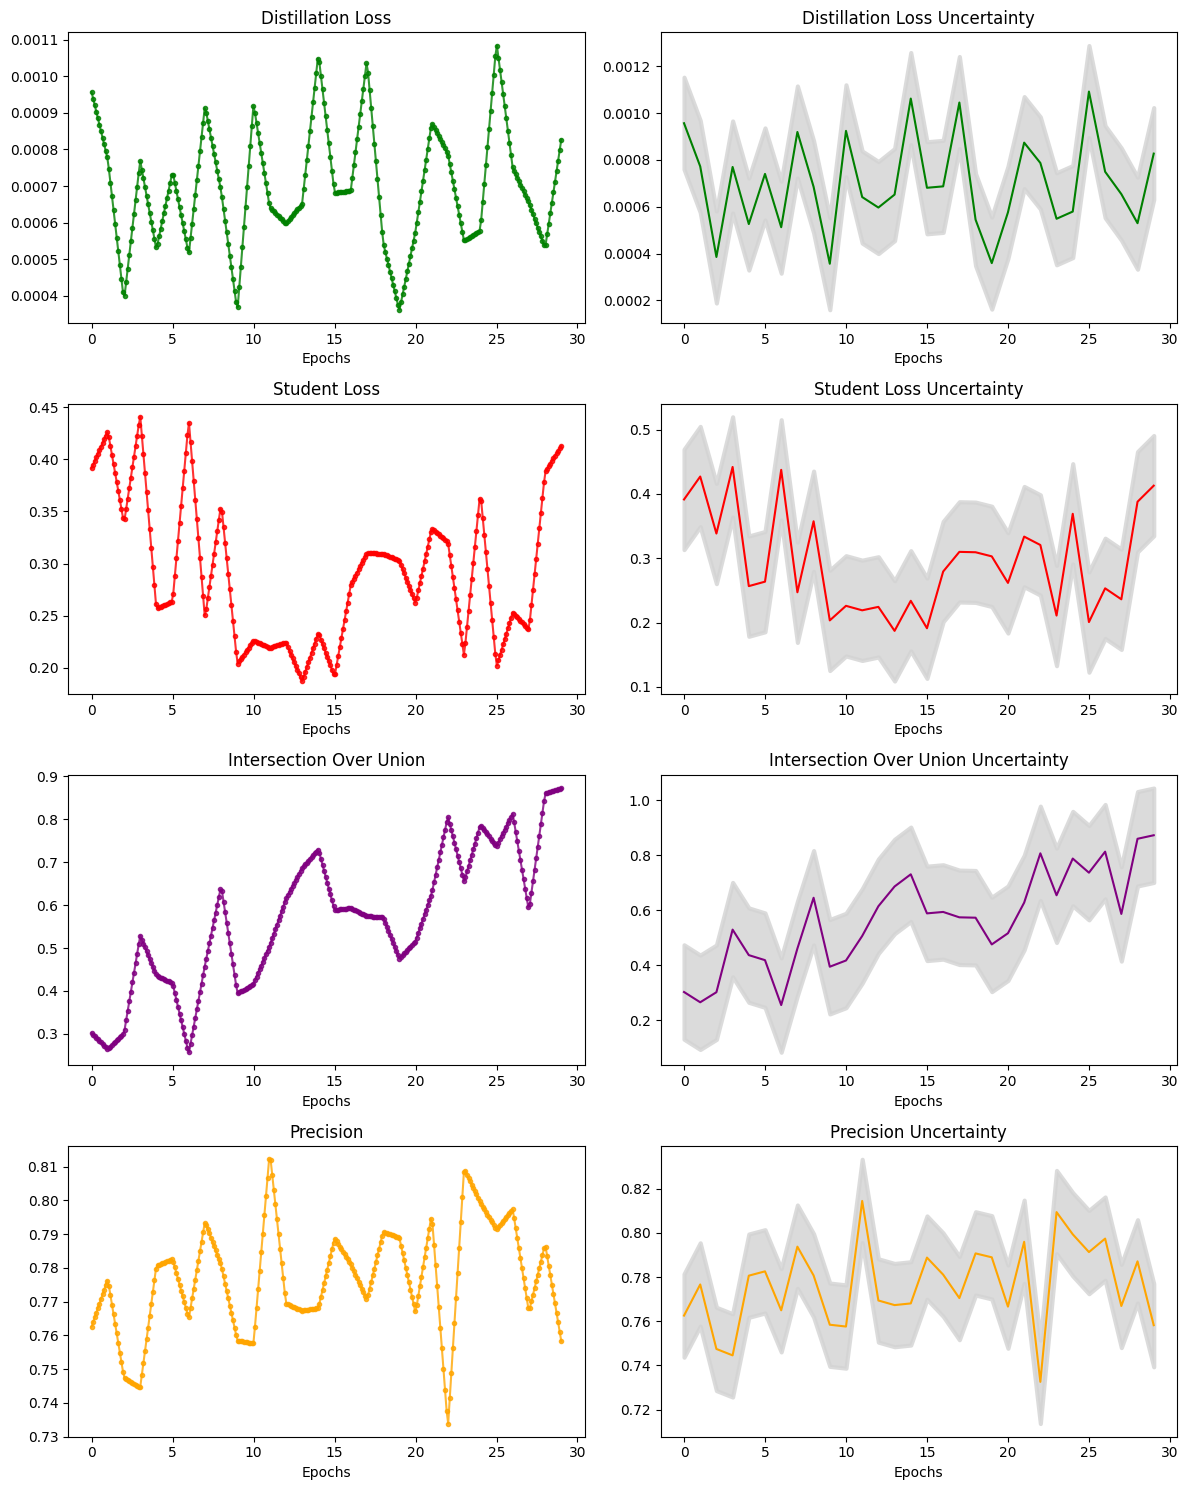

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data (replace with your own data)
metrics = [ "Distillation Loss", "Student Loss", "Intersection Over Union", "Precision"]
DAAT = {
     "Distillation Loss": distil['distillation_loss'].to_list(),
    "Student Loss": distil['student_loss'].to_list(),
    "Intersection Over Union": distil['val_intersection_over_union'].to_list(),
    "Precision": distil['val_precision'].to_list()  # Add Precision data
}

# Define colors for each row
row_colors = ['green', 'red', 'purple', 'orange']  # Add a color for the new row

# Function to calculate Bayesian uncertainty
def calculate_uncertainty(data1):
    # Use statistical methods or Bayesian approaches to calculate uncertainty
    uncertainty = np.std(data1)  # Using standard deviation as an example
    return uncertainty

# Function to generate uncertainty bounds
def generate_uncertainty_bounds(metric_data, uncertainty_data):
    lower_bound = [metric - uncertainty_data for metric in metric_data]
    upper_bound = [metric + uncertainty_data for metric in metric_data]
    return lower_bound, upper_bound

# Create a figure with subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 15))  # Extend the number of rows

for i, metric in enumerate(metrics):
    # Data for the current metric
    metric_data = DAAT[metric]

    # Calculate uncertainty for the current metric
    uncertainty_data = calculate_uncertainty(metric_data)

    # Generate uncertainty bounds for the current metric
    lower_bound, upper_bound = generate_uncertainty_bounds(metric_data, uncertainty_data)

    # Plot the original data with denser curve lines
    x_dense = np.linspace(0, len(metric_data) - 1, 10 * len(metric_data))  # Create denser x-axis values
    y_dense = np.interp(x_dense, range(len(metric_data)), metric_data)  # Interpolate for denser y-values
    axs[i, 0].plot(x_dense, y_dense, label=f"{metric}", color=row_colors[i % 5], marker='o', linestyle='-', markersize=3, alpha=0.8)
    axs[i, 0].set_title(f"{metric}")
    axs[i, 0].set_xlabel("Epochs")  # Add x-axis label

    # Plot the uncertainty with bounds as thicker lines with lighter color
    axs[i, 1].plot(range(len(metric_data)), metric_data, label=f"{metric}", color=row_colors[i % 5])
    axs[i, 1].fill_between(range(len(metric_data)), lower_bound, upper_bound, color='lightgrey', alpha=0.8, linewidth=3)
    axs[i, 1].set_title(f"{metric} Uncertainty")
    axs[i, 1].set_xlabel("Epochs")  # Add x-axis label

# Adjust layout
plt.tight_layout()

# Save the figure as a high-quality PNG
plt.savefig('DISTILLED_PLOTS.png', format='png', dpi=600)

# Show the figure
plt.show()
